In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from scipy.stats import mode
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import pickle
from sklearn.metrics import confusion_matrix

Data loading and cleaning

In [ ]:
trainData = pd.read_csv('fashion-mnist_train.csv', header=0)
testData = pd.read_csv('fashion-mnist_test.csv', header=0)

# for debugging purpose
# trainData = trainData.head(2000)
# testData = testData.head(1000)

# removing column names (1st row)
# trainData = trainData.drop(index=0).reset_index(drop=True)
# testData = testData.drop(index=0).reset_index(drop=True)

# Removing duplicates
trainData.drop_duplicates(inplace=True)
testData.drop_duplicates(inplace=True) # there can be common data in training set
# removing the data if target is null
trainData.dropna(subset=['label'], inplace=True)

# too see if everythings ok
# print(trainData.shape)
# print(testData.shape)

Features and Target splitting

In [5]:
# For training data
targetTrain = trainData['label']
featuresTrain = trainData.drop(columns=['label'])
featuresTrain.fillna(featuresTrain.mean(), inplace=True) # replace missing values of features with mean
labelsTrain = trainData.columns
feature_labels_initial_training = featuresTrain.columns

# For testing data
targetTest = testData['label']
featuresTest = testData.drop(columns=['label'])
featuresTest.fillna(featuresTest.mean(), inplace=True) # replace missing values of features with mean

# converting to numpy array
targetTrainBeforeEncode = targetTrain.values # for training accuracy
targetTrain = pd.get_dummies(targetTrain).values.astype(int) # one hot encode to 10 neurons
featuresTrain = featuresTrain.values
# targetTest = pd.get_dummies(targetTest).values.astype(int) # one hot encode to 10 neurons
targetTest = targetTest.values
featuresTest = featuresTest.values

# too see if everythings ok
# print(targetTest[:5])
# print(targetTest.shape)

print(targetTrain.shape)

(2000, 10)


Scaling function

In [6]:
# scaling the features - standard (choice 0), min-max (choice 1)
def scale_features(the_features, choice):
    feature_scaled = the_features.copy()
    if choice == 0:
        scaler = StandardScaler()
        feature_scaled = scaler.fit_transform(the_features)
    else:
        scaler = MinMaxScaler()
        feature_scaled = scaler.fit_transform(the_features)
    return feature_scaled

# Apply the scaling function to our features
choice_ = 1
scaled_features_training = scale_features(featuresTrain, choice_)
scaled_features_testing = scale_features(featuresTest, choice_)
# convert from array to dataset again with the main columns
scaled_features_training = pd.DataFrame(scaled_features_training)
scaled_features_testing = pd.DataFrame(scaled_features_testing)

# to check if everything works fine
# print(scaled_features_training.shape)
# print(scaled_features_testing.shape)

Transposing to represet a row as a neuron

In [7]:
featuresTrain = featuresTrain.T
targetTrain = targetTrain.T
targetTest = targetTest.T
featuresTest = featuresTest.T
targetTrainBeforeEncode = targetTrainBeforeEncode.T

Activation and regression function

In [8]:
def relu(x):
    return np.maximum(x, 0)

def softmax(x):
    exp_x = np.exp(x - np.max(x, axis=0, keepdims=True))
    return exp_x / (np.sum(exp_x, axis=0, keepdims=True) + 1e-10)
    # return np.exp(x) / np.sum(np.exp(x), axis=0) # sum of i-th column

def derivativeRelu(x):
    return np.array(x > 0, dtype=np.float32)

Initialization - randomly initialize ws, bs

In [9]:
def init(n_x, n_h, n_y):
    w1 = np.random.randn(n_h, n_x) * 0.01
    b1 = np.zeros((n_h, 1))
    w2 = np.random.randn(n_h, n_h) * 0.01
    b2 = np.zeros((n_h, 1))
    w3 = np.random.randn(n_y, n_h) * 0.01
    b3 = np.zeros((n_y, 1))
    # print(b1)
    parameters = {
        "w1": w1,
        "b1": b1,
        "w2": w2,
        "b2": b2,
        "w3": w3,
        "b3": b3
    }
    return parameters

# init(5,4,2)

Forward propagation ->
Zi = Wi*A(i-1) + Bi;
Ai = f(Zi);
A(out) = softmax(Zout)

In [10]:
def forwardPropagation(x, parameters, isTrain, dropout_rate):
    w1 = parameters["w1"]
    b1 = parameters["b1"]
    w2 = parameters["w2"]
    b2 = parameters["b2"]
    w3 = parameters["w3"]
    b3 = parameters["b3"]

    # First hidden layer
    z1 = np.dot(w1, x) + b1
    a1 = relu(z1)

    if isTrain:
        d1 = np.random.rand(*a1.shape) > dropout_rate # True-false mask (matrix)
        a1 = a1 * d1 / (1 - dropout_rate)  # Apply dropout

    # Second hidden layer
    z2 = np.dot(w2, a1) + b2
    a2 = relu(z2)

    if isTrain:
        d2 = np.random.rand(*a2.shape) > dropout_rate
        a2 = a2 * d2 / (1 - dropout_rate)

    # Output layer
    z3 = np.dot(w3, a2) + b3
    a3 = softmax(z3)
    return z1, a1, z2, a2, z3, a3
    

Cost function

In [11]:
def costFunction(a3, y):
    # print("Y er shape - ", y.shape)
    # print("a3 er shape - ", a3.shape)
    m = y.shape[1] # no. of observations
    epsilon = 1e-8  # Small value to avoid log(0)
    cost = -(1/m) * np.sum(y * np.log(a3 + epsilon)) # first row wise jogfol then col wise
    return cost

Back propagation => dz(out) = A(out) - y;; dzi = dw(i+1)*dz(i+1)*f'(zi);; dwi = 1/m*dzi*A(i-1);; dBi = 1/m*sum(dZi,1)

In [12]:
def backPropagation(x, y, parameters, forwardPropVar):
    m = y.shape[1] # no of observations
    w1 = parameters["w1"]
    b1 = parameters["b1"]
    w2 = parameters["w2"]
    b2 = parameters["b2"]
    w3 = parameters["w3"]
    b3 = parameters["b3"]
    z1, a1, z2, a2, z3, a3 = forwardPropVar

    dz3 = a3 - y
    dw3 = (1/m) * np.dot(dz3, a2.T)
    db3 = (1/m) * np.sum(dz3, axis=1, keepdims=True)

    dz2 = (1/m) * np.dot(w3.T, dz3) * derivativeRelu(a2)
    dw2 = (1/m) * np.dot(dz2, a1.T)
    db2 = (1/m) * np.sum(dz2, axis=1, keepdims=True)

    dz1 = (1/m) * np.dot(w2.T, dz2) * derivativeRelu(a1)
    dw1 = (1/m) * np.dot(dz1, x.T)
    db1 = (1/m) * np.sum(dz1, axis=1, keepdims=True)

    return dw1, db1, dw2, db2, dw3, db3
    

Update parameters

In [13]:
def updateParameters(parameters, dsFromBackPropagation, learningRate, beta1, beta2, epsilon, vdwPrev, vdbPrev, sdwPrev, sdbPrev):
    w1 = parameters["w1"]
    b1 = parameters["b1"]
    w2 = parameters["w2"]
    b2 = parameters["b2"]
    w3 = parameters["w3"]
    b3 = parameters["b3"]
    dw1, db1, dw2, db2, dw3, db3 = dsFromBackPropagation
    
    # Adam optimizer

    # momentum
    vdw1 = (beta1 * vdwPrev[0]) + ((1-beta1) * dw1)
    vdw2 = (beta1 * vdwPrev[1]) + ((1-beta1) * dw2)
    vdws = [vdw1, vdw2]

    vdb1 = (beta1 * vdbPrev[0]) + ((1-beta1) * db1)
    vdb2 = (beta1 * vdbPrev[1]) + ((1-beta1) * db2)
    vdbs = [vdb1, vdb2]

    vdw3 = (beta1 * vdwPrev[2]) + ((1-beta1) * dw3)
    vdb3 = (beta1 * vdbPrev[2]) + ((1-beta1) * db3)
    vdws.append(vdw3)
    vdbs.append(vdb3)

    # rms prop
    sdw1 = (beta2 * sdwPrev[0]) + ((1-beta2)*(dw1**2))
    sdw2 = (beta2 * sdwPrev[1]) + ((1-beta2)*(dw2**2))
    sdws = [sdw1, sdw2]

    sdb1 = (beta2 * sdbPrev[0]) + ((1-beta2)*(db1**2))
    sdb2 = (beta2 * sdbPrev[1]) + ((1-beta2)*(db2**2))
    sdbs = [sdb1, sdb2]

    sdw3 = (beta2 * sdwPrev[2]) + ((1-beta2)*(dw3**2))
    sdb3 = (beta2 * sdbPrev[2]) + ((1-beta2)*(db3**2))
    sdws.append(sdw3)
    sdbs.append(sdb3)

    w1 = w1 - (learningRate * vdw1/(sdw1+epsilon)**0.5)
    b1 = b1 - (learningRate * vdb1/(sdb1+epsilon)**0.5)
    w2 = w2 - (learningRate * vdw2/(sdw2+epsilon)**0.5)
    b2 = b2 - (learningRate * vdb2/(sdb2+epsilon)**0.5)
    w3 = w3 - (learningRate * vdw3/(sdw3+epsilon)**0.5)
    b3 = b3 - (learningRate * vdb3/(sdb3+epsilon)**0.5)
    parameters = {
        "w1": w1,
        "b1": b1,
        "w2": w2,
        "b2": b2,
        "w3": w3,
        "b3": b3
    }
    return parameters, vdws, vdbs, sdws, sdbs

Split into mini batches

In [14]:
def getMinibatches(x, y, batchSize):
    m = x.shape[1]
    # Shuffle the data
    permutation = np.random.permutation(m)
    shuffled_x = x[:, permutation]
    shuffled_y = y[:, permutation]
    # Split the data into mini batches
    num_batches = m // batchSize
    batches = []
    for i in range(num_batches):
        x_batch = shuffled_x[:, i*batchSize:(i+1)*batchSize]
        y_batch = shuffled_y[:, i*batchSize:(i+1)*batchSize]
        batches.append((x_batch, y_batch))

    return batches

Train the model

In [15]:
def train(x, y, n_h, learningRate, itn, dropOut):
    n_x = x.shape[0] # no. of neurons in input layer
    n_y = 10
    
    # Adam optimization variables
    beta1 = 0.9
    beta2 = 0.999
    epsilon = 0.00000001
    vdws = [0,0,0]
    vdbs = [0,0,0]
    sdws = [0,0,0] 
    sdbs = [0,0,0]

    parameters = init(n_x, n_h, n_y)
    # with open('trainedModel(2)003.pkl', 'rb') as file:
    #     loaded_parameters = pickle.load(file)
    # parameters = loaded_parameters
    
    batchSize = 512
    costList = []
    a2 = np.zeros(x.shape[1])
    a3 = np.zeros(x.shape[1])
    for i in range(itn):
        miniBatches = getMinibatches(x, y, batchSize)
        for batch in miniBatches:
            x_batch, y_batch = batch
            forwardParameters = forwardPropagation(x, parameters, True, dropOut)
            z1, a1, z2, a2, z3, a3 = forwardParameters
            backwardPropagationDs = backPropagation(x, y, parameters, forwardParameters)
            parameters, vdws, vdbs, sdws, sdbs = updateParameters(parameters, backwardPropagationDs, learningRate, beta1, beta2, epsilon, vdws, vdbs, sdws, sdbs)
            
            # if(i % (itn / 100) == 0): # to check if the model works well
            #     cost = costFunction(a3, y)
            #     print(cost)
            #     print(a3.shape)
            
            cost = costFunction(a3, y)
            costList.append(cost)
        
            
    return parameters, costList

Get the trained model

In [16]:
itn = 1
n_h = 512
learningRate = 0.003
dropOut = 0.15
trainedParameters, costList = train(featuresTrain, targetTrain, n_h, learningRate, itn, dropOut)

In [ ]:
# # if needed --
# with open('trainedModel.pkl', 'rb') as file:
#     loaded_parameters = pickle.load(file)
#     trainedParameters = loaded_parameters

Test the model with training data and test data --> get output by forward propagation with the trained parameter

In [18]:
# with training data
z1, a1, z2, a2, z3, a3 = forwardPropagation(featuresTrain[:, :2000], trainedParameters, False, dropOut)
y_predTraining = a3
y_predTraining = np.argmax(y_predTraining, 0) # return the index of max value

# with validation data
n_observations = featuresTrain.shape[1]
indices = np.random.choice(n_observations, size=1000, replace=False) # Randomly shuffle the indices
x_val = featuresTrain[:, indices]  # Selected x data for validation
y_val = targetTrain[:, indices]  # Selected y data for validation
z1, a1, z2, a2, z3, a3 = forwardPropagation(x_val, trainedParameters, False, dropOut)
y_predValidation = a3
y_predValidation = np.argmax(y_predValidation, 0) # return the index of max value

Saving the model with pickle

In [19]:
with open('trainedModel.pkl', 'wb') as file:
    pickle.dump(trainedParameters, file)

# with open('trainedModel.pkl', 'rb') as file:
#     loaded_parameters = pickle.load(file)


Performance Metrics

In [19]:
# for training data
y_test = targetTrainBeforeEncode[:2000]
trainingAccuracy = accuracy_score(y_test, y_predTraining)*100
trainingF1 = f1_score(y_test, y_predTraining, average='macro')
trainingLoss = abs(costFunction(y_predTraining.reshape(1, -1), y_test.reshape(1, -1)))
# print("Training acc - ", trainingAccuracy)
# print("Training f1 - ", trainingF1)
# print("Training loss - ", trainingLoss)

# for validation data
y_test = y_val
y_test = np.argmax(y_test, 0)
validationAcc = accuracy_score(y_test, y_predValidation)*100
validationF1 = f1_score(y_test, y_predValidation, average='macro')
validationLoss = abs(costFunction(y_predValidation.reshape(1, -1), y_test.reshape(1, -1)))
# print("Validation acc - ", validationAcc)
# print("Validation f1 - ", validationF1)
# print("Validation loss - ", validationLoss)
# precision = precision_score(y_test, y_pred, average='macro')
# recall = recall_score(y_test, y_pred, average='macro')

# Create table
metrics = {
    "Metric": ["Accuracy", "F1 Score", "Loss"],
    "Training": [trainingAccuracy, trainingF1, trainingLoss],
    "Validation": [validationAcc, validationF1, validationLoss]
}
df = pd.DataFrame(metrics)
styled_table = df.style.set_table_styles(
    [{'selector': 'table', 'props': [('border', '1px solid black')]},
     {'selector': 'th', 'props': [('border', '1px solid black')]},
     {'selector': 'td', 'props': [('border', '1px solid black')]}]
)

# Display the table
styled_table

,Metric,Training,Validation
0,Accuracy,32.400000,31.100000
1,F1 Score,0.234871,0.229313
2,Loss,25.208262,24.686983


Graphs plotting

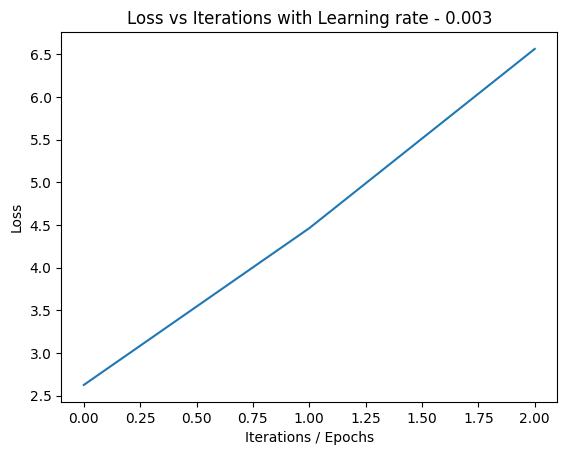

In [20]:
plt.plot(costList, label='Loss')
plt.xlabel('Iterations / Epochs')
plt.ylabel('Loss')
theTitle = 'Loss vs Iterations with Learning rate - ' + str(learningRate)
plt.title(theTitle)
plt.show()


Confusion Matrix

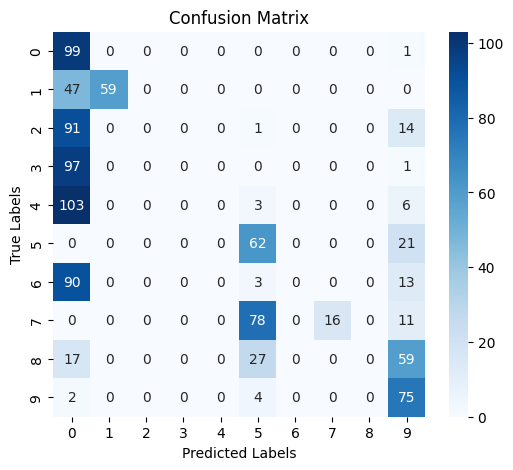

In [21]:
cm = confusion_matrix(y_test, y_predValidation)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

For testing with the best model got so far

In [22]:
with open('trainedModel.pkl', 'rb') as file:
    loaded_parameters = pickle.load(file)

# Predictions with test data
z1, a1, z2, a2, z3, a3 = forwardPropagation(featuresTest, loaded_parameters, False, dropOut)
y_pred = a3
y_pred = np.argmax(y_pred, 0) # return the index of max value

# Performance metrics
# for test data
y_test = targetTest
testAcc = accuracy_score(y_test, y_pred)*100
testF1 = f1_score(y_test, y_pred, average='macro')*100
testPrecision = precision_score(y_test, y_pred, average='macro')*100
print("Test acc - ", testAcc)
print("Test f1 - ", testF1)
print("Test precision - ", testPrecision)


Test acc -  83.1
Test f1 -  83.29210689130576
Test precision -  83.79170490487063
